In [31]:
# Necessary imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


In [32]:

# Load the dataset
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

data.head()


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [33]:
# Separating features and target
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

# Encoding target variable: Malignant (M) as 1, Benign (B) as 0
y = np.where(y == "M", 1, 0)

# Split the dataset to keep aside 100 samples from each class for testing
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]
y_class_0 = y[class_0_indices]
y_class_1 = y[class_1_indices]

# Separate 100 samples from each class for the test set
X_test_class_0, X_train_class_0 = X_class_0[:100], X_class_0[100:]
X_test_class_1, X_train_class_1 = X_class_1[:100], X_class_1[100:]
y_test_class_0, y_train_class_0 = y_class_0[:100], y_class_0[100:]
y_test_class_1, y_train_class_1 = y_class_1[:100], y_class_1[100:]

# Combine the class-separated training and test sets
X_train = np.concatenate((X_train_class_0, X_train_class_1))
y_train = np.concatenate((y_train_class_0, y_train_class_1))
X_test_small = np.concatenate((X_test_class_0, X_test_class_1))
y_test_small = np.concatenate((y_test_class_0, y_test_class_1))



In [34]:

np.random.seed(42)

# Determine the number of samples in the minority class
minority_class_size = min(len(X_train_class_0), len(X_train_class_1))
print(minority_class_size)

# Calculate the number of samples to duplicate from the majority class
majority_class_size = 3 * minority_class_size - len(X_train_class_1)
print(majority_class_size)

# Randomly select samples to duplicate from the majority class
indices_to_duplicate = np.random.choice(len(X_train_class_1), majority_class_size, replace=True)

# Extract the samples to be duplicated
X_to_duplicate = X_train_class_1[indices_to_duplicate]
y_to_duplicate = y_train_class_1[indices_to_duplicate]

# Add noise to the duplicated samples
noise_factor = 0.01
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_to_duplicate.shape)
X_to_duplicate_noisy = X_to_duplicate + noise

# Combine the original training data with the noisy duplicates
X_train_imbalanced = np.vstack((X_train, X_to_duplicate_noisy))
y_train_imbalanced = np.hstack((y_train, y_to_duplicate))
print(len(X_train_imbalanced))
print(len(y_train_imbalanced))

112
224
593
593


In [35]:
# Calculate the number of labels to flip for each class
num_to_flip_class_0 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 0]))
num_to_flip_class_1 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 1]))

# Randomly choose the indices of labels to flip
indices_to_flip_class_0 = np.random.choice(np.where(y_train_imbalanced == 0)[0], num_to_flip_class_0, replace=False)
indices_to_flip_class_1 = np.random.choice(np.where(y_train_imbalanced == 1)[0], num_to_flip_class_1, replace=False)

# Flip the labels
y_train_imbalanced[indices_to_flip_class_0] = 1
y_train_imbalanced[indices_to_flip_class_1] = 0



In [36]:

# Determine the number of input features (number of columns in X_train_imbalanced)
input_dim = X_train_imbalanced.shape[1]
print(input_dim)

# Create the neural network model with one hidden layer of size twice the number of input features
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and the ADAM optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


30


In [37]:


results_train = []
results_test = []
conf_mat_train = []
conf_mat_test = []
weights_list = []

for i in range(10): 
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

    # Save the weights
    weights = model.get_weights()
    weights_list.append(weights)

    # Evaluate the model
    train_acc = history.history['accuracy']
    test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)[1]

    # Save the results
    results_train.append(train_acc)
    results_test.append(test_acc)

    # Confusion matrices
    y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
    y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)

    conf_mat_train.append(confusion_matrix(y_train_imbalanced, y_pred_train))
    conf_mat_test.append(confusion_matrix(y_test_small, y_pred_test))

# Calculate the mean results
mean_results_train = np.mean(results_train, axis=0)
mean_results_test = np.mean(results_test)


7/7 [==============================] - 0s 322us/step


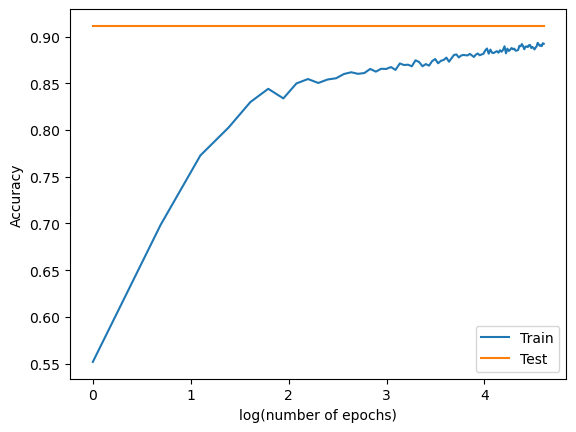

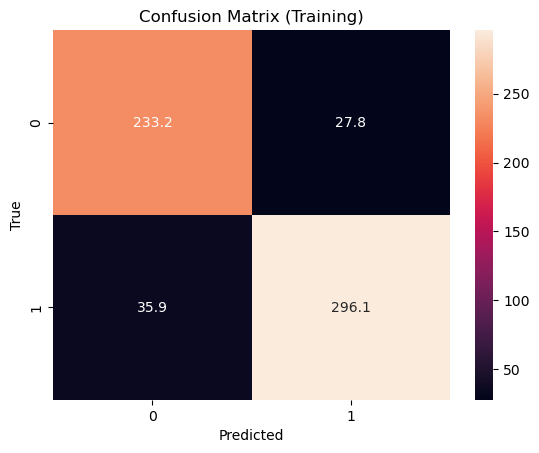

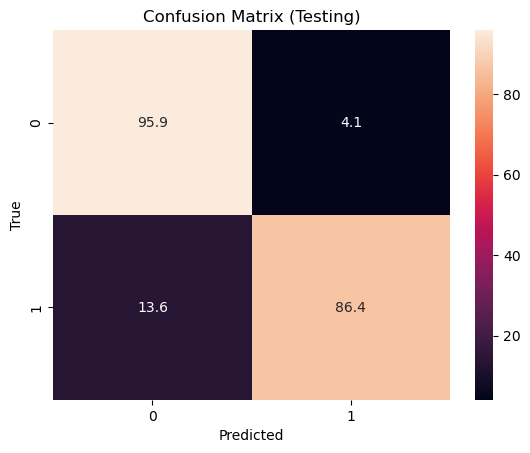

In [38]:

# Plot the results
plt.plot(np.log(range(1, 101)), mean_results_train, label="Train")
plt.plot(np.log(range(1, 101)), [mean_results_test] * 100, label="Test")
plt.xlabel("log(number of epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Confusion matrices
mean_conf_mat_train = np.mean(conf_mat_train, axis=0)
mean_conf_mat_test = np.mean(conf_mat_test, axis=0)

# Plotting confusion matrices
plt.figure()
sns.heatmap(mean_conf_mat_train, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Training)")
plt.show()

plt.figure()
sns.heatmap(mean_conf_mat_test, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Testing)")
plt.show()

# Saving weights
file = open('weights.txt', 'w')
file.write(str(weights_list))
file.close()


7/7 [==============================] - 0s 297us/step


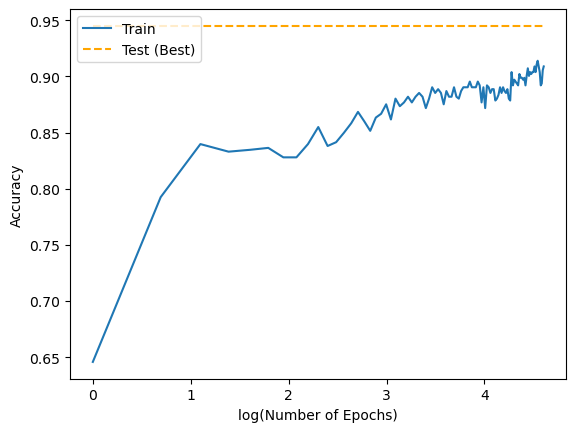

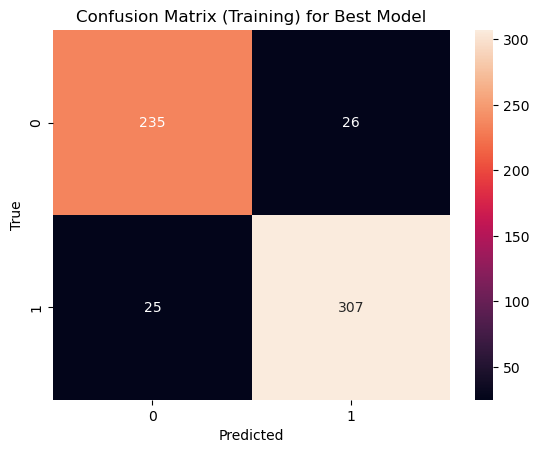

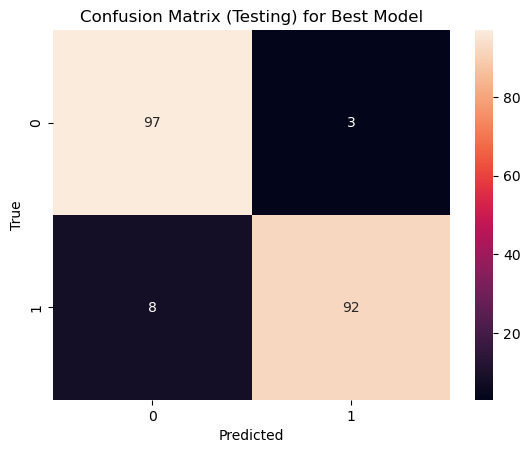

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

best_test_acc = 0  # Initialize the best test accuracy
best_model = None  # Placeholder for the best model
best_weights = None  # Placeholder for the best model's weights
best_epoch_acc = None  # Placeholder for the best model's epoch accuracy
best_conf_mat_train = None  # Placeholder for the best model's training confusion matrix
best_conf_mat_test = None  # Placeholder for the best model's testing confusion matrix

for i in range(10):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

    # Evaluate the model
    test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)[1]

    # Update the best model if the current one is better
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model = model
        best_weights = model.get_weights()
        best_epoch_acc = history.history['accuracy']
        
        # Confusion matrices for the best model
        y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
        y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)
        best_conf_mat_train = confusion_matrix(y_train_imbalanced, y_pred_train)
        best_conf_mat_test = confusion_matrix(y_test_small, y_pred_test)

# Plot the results for the best model
plt.plot(np.log(range(1, 101)), best_epoch_acc, label="Train")
plt.hlines(best_test_acc, xmin=0, xmax=np.log(100), colors='orange', linestyles='dashed', label="Test (Best)")
plt.xlabel("log(Number of Epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plotting confusion matrices for the best model
plt.figure()
sns.heatmap(best_conf_mat_train, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Training) for Best Model")
plt.show()

plt.figure()
sns.heatmap(best_conf_mat_test, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Testing) for Best Model")
plt.show()

# Saving weights of the best model
with open('weights_best_model.txt', 'w') as file:
    file.write(str(best_weights))


In [9]:
id = 386916341
es_variant = id % 4
print(es_variant)

1


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Load the dataset
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

# Separating features and target
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values
y = np.where(y == "M", 1, 0)

# Splitting the dataset (reusing the imbalanced and label noise introduced set from the HW0)

# Define the neural network model
input_dim = X.shape[1]  # Number of features
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_dim=input_dim, activation='sigmoid'),  # Adjusted to match the 10-20-1 architecture
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=1)  # Training on the full dataset for simplicity

# Extract first layer weights
weights_first_layer = model.layers[0].get_weights()[0]

# Verify shape (should be (input_dim, 20))
print("Shape of first layer weights:", weights_first_layer.shape)


Epoch 1/100
18/18 [==============================] - 0s 438us/step - loss: 0.7876 - accuracy: 0.3673
Epoch 2/100
18/18 [==============================] - 0s 433us/step - loss: 0.7253 - accuracy: 0.3620
Epoch 3/100
18/18 [==============================] - 0s 464us/step - loss: 0.6946 - accuracy: 0.3656
Epoch 4/100
18/18 [==============================] - 0s 356us/step - loss: 0.6491 - accuracy: 0.6309
Epoch 5/100
18/18 [==============================] - 0s 418us/step - loss: 0.6192 - accuracy: 0.8225
Epoch 6/100
18/18 [==============================] - 0s 347us/step - loss: 0.6087 - accuracy: 0.8067
Epoch 7/100
18/18 [==============================] - 0s 369us/step - loss: 0.5986 - accuracy: 0.8067
Epoch 8/100
18/18 [==============================] - 0s 336us/step - loss: 0.5894 - accuracy: 0.8243
Epoch 9/100
18/18 [==============================] - 0s 336us/step - loss: 0.5832 - accuracy: 0.8014
Epoch 10/100
18/18 [==============================] - 0s 371us/step - loss: 0.5761 - accura

In [11]:
import numpy as np

# GA parameters
num_weights = weights_first_layer.size  # Total number of weights in the first layer
population_size = 2 * num_weights  # Population size
gene_length = num_weights  # Length of the bit vector for each individual

# Initialize GA population
np.random.seed(42)  # For reproducibility
population = np.zeros((population_size, gene_length), dtype=int)

for i in range(population_size):
    ones_indices = np.random.choice(range(gene_length), size=gene_length // 2, replace=False)
    population[i, ones_indices] = 1

# Verify
print("Population shape:", population.shape)
print("Example individual:", population[0])
print("Number of 1s in the first individual:", np.sum(population[0]))


Population shape: (1200, 600)
Example individual: [1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1
 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1
 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0
 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1
 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0
 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0
 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0
 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1
 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1
 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0
 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1

In [12]:
def evaluate_fitness(individual, original_weights, X_test, y_test):
    """
    Evaluate the fitness of an individual by masking weights in the neural network.

    Parameters:
    - individual: np.array, a bit vector representing which weights to keep.
    - original_weights: List, original weights of the neural network.
    - X_test: np.array, test set features.
    - y_test: np.array, test set labels.

    Returns:
    - accuracy: The accuracy of the neural network with masked weights.
    """
    # Clone the original model
    cloned_model = tf.keras.models.clone_model(model)
    cloned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Apply the mask to the first layer's weights
    masked_weights = np.multiply(original_weights[0], individual.reshape(original_weights[0].shape))
    
    # Update the model's weights
    new_weights = [masked_weights] + original_weights[1:]
    cloned_model.set_weights(new_weights)
    
    # Evaluate the model's performance
    loss, accuracy = cloned_model.evaluate(X_test, y_test, verbose=0)
    
    return accuracy

# preparing the inputs
original_weights = model.get_weights()  # Assuming 'model' is your trained model from earlier steps




In [13]:
import numpy as np

def linear_ranking_selection(population, fitness_scores, selection_size):
    """
    Selects individuals based on linear ranking selection.

    Parameters:
    - population: np.array, the current population.
    - fitness_scores: np.array, fitness scores of the population.
    - selection_size: int, the number of individuals to select.

    Returns:
    - selected_individuals: np.array, the selected individuals for the next generation.
    """
    # Rank individuals based on fitness scores
    ranked_indices = np.argsort(fitness_scores)
    # Compute linear probabilities
    ranks = np.arange(1, len(population) + 1)
    selection_probabilities = ranks / ranks.sum()
    # Select individuals based on their ranks
    selected_indices = np.random.choice(ranked_indices, size=selection_size, replace=True, p=selection_probabilities)
    selected_individuals = population[selected_indices]
    
    return selected_individuals



In [14]:
def uniform_crossover(selected_population, crossover_rate=0.9):
    """
    Apply uniform crossover to the selected population.

    Parameters:
    - selected_population: np.array, selected individuals for crossover.
    - crossover_rate: float, probability of applying crossover to a pair of parents.

    Returns:
    - offspring_population: np.array, offspring produced by uniform crossover.
    """
    offspring_population = []
    for i in range(0, len(selected_population), 2):
        parent1, parent2 = selected_population[i], selected_population[i+1]
        if np.random.rand() < crossover_rate:
            # Uniform crossover
            mask = np.random.randint(2, size=len(parent1))
            child1 = np.where(mask, parent1, parent2)
            child2 = np.where(mask, parent2, parent1)
            offspring_population.extend([child1, child2])
        else:
            # If crossover is not applied, copy the parents directly to the next generation
            offspring_population.extend([parent1, parent2])

    return np.array(offspring_population)



In [15]:
def mutate(offspring_population, mutation_rate):
    """
    Apply mutation to the offspring population.

    Parameters:
    - offspring_population: np.array, offspring to mutate.
    - mutation_rate: float, probability of mutating each gene (bit).

    Returns:
    - mutated_population: np.array, mutated offspring population.
    """
    mutated_population = np.copy(offspring_population)
    for i in range(len(mutated_population)):
        for j in range(len(mutated_population[i])):
            if np.random.rand() < mutation_rate:
                mutated_population[i][j] = 1 - mutated_population[i][j]  # Flip the bit

    return mutated_population



In [16]:
def repair_individual(individual):
    """
    Repair an individual so that exactly 50% of its bits are 1s and 50% are 0s.

    Parameters:
    - individual: np.array, the individual to be repaired.

    Returns:
    - individual: np.array, the repaired individual.
    """
    num_ones_needed = len(individual) // 2 - np.sum(individual)
    if num_ones_needed > 0:  # Need more 1s
        zero_indices = np.where(individual == 0)[0]
        ones_to_flip = np.random.choice(zero_indices, num_ones_needed, replace=False)
        individual[ones_to_flip] = 1
    elif num_ones_needed < 0:  # Need more 0s
        one_indices = np.where(individual == 1)[0]
        zeros_to_flip = np.random.choice(one_indices, -num_ones_needed, replace=False)
        individual[zeros_to_flip] = 0
    return individual


In [17]:
import numpy as np

# Genetic Algorithm parameters
num_generations = 100  # Number of generations to evolve the population
# Calculate the number of weights in the first layer
first_layer_weights = model.layers[0].get_weights()[0]  
num_first_layer_weights = first_layer_weights.size

# Set the population size to be twice the number of first-layer weights
population_size = 2 * num_first_layer_weights
print("Polpulation size", population_size )
# Now initialize your population matrix
population = np.array([np.round(np.random.rand(num_first_layer_weights)).astype(int) for _ in range(population_size)])
crossover_rate = 0.9   # Probability of applying crossover
mutation_rate = 2 / (10 * 21)  # Mutation rate, 2 divided by the number of connections
average_fitness_values = []  # List to store the average fitness value in each generation

# Initialize fitness evaluation for the population
fitnesses = np.array([evaluate_fitness(individual, original_weights, X_test_small, y_test_small) for individual in population])
print(f"Initial max fitness: {np.max(fitnesses)}")

for generation in range(num_generations):
    
    try: 
        # Selection
        selected_population = linear_ranking_selection(population, fitnesses, population_size)
        print(f"Generation {generation + 1}: Selection done")

        # Uniform Crossover
        offspring_population = uniform_crossover(selected_population, crossover_rate)
        print(f"Generation {generation + 1}: Crossover applied")

        # Mutation
        mutated_population = mutate(offspring_population, mutation_rate)
        print(f"Generation {generation + 1}: Mutation applied")

        # Repair Mechanism: Ensure 50% mask constraint
        for individual in mutated_population:
            repair_individual(individual)
        print(f"Generation {generation + 1}: Repair mechanism enforced")
        
        # Evaluate Fitness
        new_fitnesses = np.array([evaluate_fitness(individual, original_weights, X_test_small, y_test_small)
                                  for individual in mutated_population])

        # Store average fitness
        average_fitness = np.mean(new_fitnesses)
        average_fitness_values.append(average_fitness)
        print(f"Generation {generation + 1} completed: Average Fitness = {average_fitness}")


    
        # Very Weak Elitism: Keeping the best individual
        best_index = np.argmax(fitnesses)
        best_individual = population[best_index]
        best_fitness = fitnesses[best_index]
        print(f"Generation {generation + 1}: Best fitness = {best_fitness}")

        # Ensure the best individual is carried over to the new population
        if np.max(new_fitnesses) < best_fitness:
            # Replace the worst new individual with the best from the previous generation
            worst_new_index = np.argmin(new_fitnesses)
            mutated_population[worst_new_index] = best_individual
            new_fitnesses[worst_new_index] = best_fitness
            print(f"Generation {generation + 1}: Elitism applied, best individual carried over")

        # Update the population and fitnesses for the next generation
        population = mutated_population
        fitnesses = new_fitnesses

        # Logging progress
        print(f"Generation {generation + 1} completed: Max Fitness = {np.max(fitnesses)}\n")
        
    except Exception as e:
        print(f"An error occurred at generation {generation + 1}: {e}")
        break  # Break out of the loop in case of an error

# After the GA loop, additional evaluation of the best individual can be done
best_overall_index = np.argmax(fitnesses)
best_overall_individual = population[best_overall_index]
print(f"Best individual in final generation: {best_overall_individual}")
print(f"Best overall fitness: {np.max(fitnesses)}")




Polpulation size 1200
Initial max fitness: 0.9449999928474426
Generation 1: Selection done
Generation 1: Crossover applied
Generation 1: Mutation applied
Generation 1: Repair mechanism enforced
Generation 1 completed: Average Fitness = 0.5956833328182498
Generation 1: Best fitness = 0.9449999928474426
Generation 1 completed: Max Fitness = 0.9449999928474426

Generation 2: Selection done
Generation 2: Crossover applied
Generation 2: Mutation applied
Generation 2: Repair mechanism enforced
Generation 2 completed: Average Fitness = 0.6258458330482245
Generation 2: Best fitness = 0.9449999928474426
Generation 2: Elitism applied, best individual carried over
Generation 2 completed: Max Fitness = 0.9449999928474426

Generation 3: Selection done
Generation 3: Crossover applied
Generation 3: Mutation applied
Generation 3: Repair mechanism enforced
Generation 3 completed: Average Fitness = 0.6529500004152456
Generation 3: Best fitness = 0.9449999928474426
Generation 3 completed: Max Fitness = 0

In [18]:
def apply_mask_to_model(model, mask, original_weights):
    masked_model = tf.keras.models.clone_model(model)
    masked_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    new_first_layer_weights = np.multiply(original_weights[0], mask.reshape(original_weights[0].shape))
    new_weights = [new_first_layer_weights] + original_weights[1:]
    masked_model.set_weights(new_weights)
    
    return masked_model

def generate_confusion_matrix(model, X, y):
    predictions = (model.predict(X) > 0.5).astype(int).flatten()
    conf_mat = confusion_matrix(y, predictions)
    return conf_mat

def generate_baseline_mask(weights, mask_size):
    """
    Generate a mask for the baseline model by keeping only the highest magnitude weights.

    Parameters:
    - weights: Original weights of the first layer.
    - mask_size: The number of weights to keep (half the weights for a 50% mask).

    Returns:
    - baseline_mask: A mask to apply to the weights for the baseline model.
    """
    # Flatten the weights to consider their magnitudes
    flattened_weights = weights.flatten()
    # Get the indices of the top `mask_size` weights by magnitude
    top_indices = np.argsort(np.abs(flattened_weights))[-mask_size:]
    
    # Initialize a mask of zeros
    baseline_mask = np.zeros_like(flattened_weights)
    # Set the top indices to 1
    baseline_mask[top_indices] = 1
    
    return baseline_mask.reshape(weights.shape)

baseline_mask = generate_baseline_mask(weights_first_layer, weights_first_layer.size // 2)
baseline_model = apply_mask_to_model(model, baseline_mask, original_weights)


In [25]:
# Evaluate the baseline model on the training data
_, baseline_train_accuracy = baseline_model.evaluate(X_train_imbalanced, y_train_imbalanced, verbose=0)
print(f"Baseline model train accuracy: {baseline_train_accuracy}")

# Generate confusion matrix for the training data
conf_mat_baseline_train = generate_confusion_matrix(baseline_model, X_train_imbalanced, y_train_imbalanced)
print("Confusion Matrix - Baseline Model (Training Data):")
print(conf_mat_baseline_train)

# Evaluate the baseline model on the test data
_, baseline_test_accuracy = baseline_model.evaluate(X_test_small, y_test_small, verbose=0)
print(f"Baseline model test accuracy: {baseline_test_accuracy}")

# Generate confusion matrix for the test data
conf_mat_baseline_test = generate_confusion_matrix(baseline_model, X_test_small, y_test_small)
print("Confusion Matrix - Baseline Model (Test Data):")
print(conf_mat_baseline_test)


Baseline model train accuracy: 0.5109612345695496
19/19 [==============================] - 0s 269us/step
Confusion Matrix - Baseline Model (Training Data):
[[257   4]
 [286  46]]
Baseline model test accuracy: 0.5899999737739563
7/7 [==============================] - 0s 312us/step
Confusion Matrix - Baseline Model (Test Data):
[[100   0]
 [ 82  18]]


In [26]:
best_masked_model = apply_mask_to_model(model, best_overall_individual, original_weights)


# Evaluate the best GA-optimized model on the training data
_, best_model_train_accuracy = best_masked_model.evaluate(X_train_imbalanced, y_train_imbalanced, verbose=0)
print(f"Best GA-optimized model train accuracy: {best_model_train_accuracy}")

# Generate confusion matrix for the training data
conf_mat_best_ga_train = generate_confusion_matrix(best_masked_model, X_train_imbalanced, y_train_imbalanced)
print("Confusion Matrix - Best GA Model (Training Data):")
print(conf_mat_best_ga_train)

# Evaluate the best GA-optimized model on the test data (already done, included here for completeness)
_, best_model_test_accuracy = best_masked_model.evaluate(X_test_small, y_test_small, verbose=0)
print(f"Best GA-optimized model test accuracy: {best_model_test_accuracy}")

# Generate confusion matrix for the test data (already done, included here for completeness)
conf_mat_best_ga_test = generate_confusion_matrix(best_masked_model, X_test_small, y_test_small)
print("Confusion Matrix - Best GA Model (Test Data):")
print(conf_mat_best_ga_test)


Best GA-optimized model train accuracy: 0.8735244274139404
19/19 [==============================] - 0s 302us/step
Confusion Matrix - Best GA Model (Training Data):
[[206  55]
 [ 20 312]]
Best GA-optimized model test accuracy: 0.9649999737739563
7/7 [==============================] - 0s 315us/step
Confusion Matrix - Best GA Model (Test Data):
[[95  5]
 [ 2 98]]


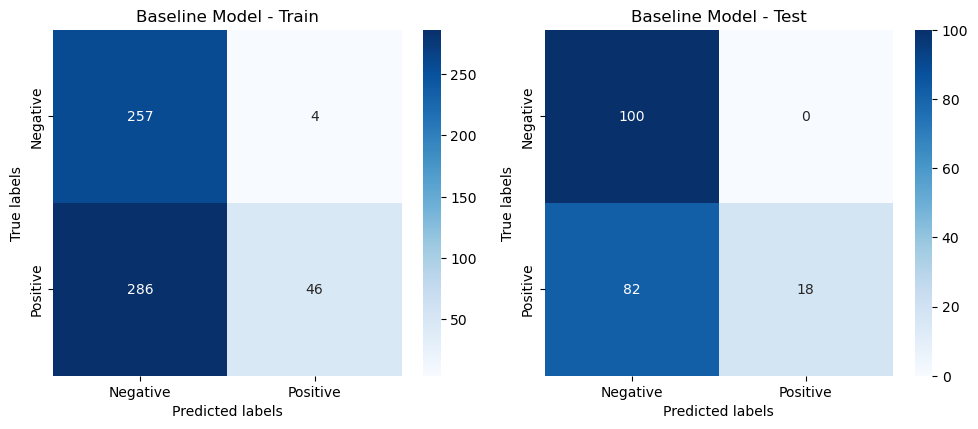

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title, subplot, fig, labels=['Negative', 'Positive']):
    """
    Plots a confusion matrix using seaborn's heatmap.

    Parameters:
    - cm: Confusion matrix to plot.
    - title: Title for the plot.
    - subplot: The subplot to draw the confusion matrix on.
    - fig: The overall figure object.
    - labels: The labels for the classification outcomes.
    """
    ax = fig.add_subplot(subplot)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

# conf_mat_baseline_train, conf_mat_baseline_test, conf_mat_best_ga_train, conf_mat_best_ga_test

fig = plt.figure(figsize=(10, 8))

plot_confusion_matrix(conf_mat_baseline_train, 'Baseline Model - Train', 221, fig)
plot_confusion_matrix(conf_mat_baseline_test, 'Baseline Model - Test', 222, fig)

plt.tight_layout()
plt.show()


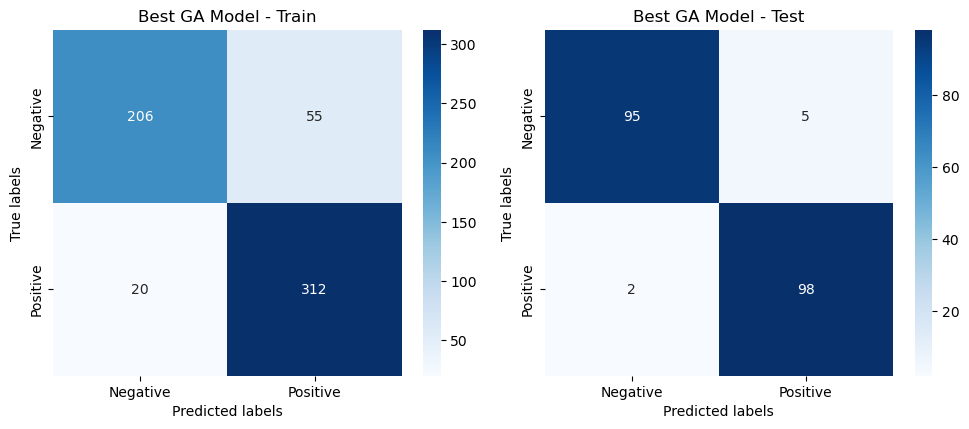

In [29]:
fig = plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_mat_best_ga_train, 'Best GA Model - Train', 223, fig)
plot_confusion_matrix(conf_mat_best_ga_test, 'Best GA Model - Test', 224, fig)

plt.tight_layout()
plt.show()
